<a href="https://colab.research.google.com/github/adindanabila/Analisis_TURF/blob/main/Statmul_Adinda_Nabila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install Library
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.4 MB/s eta 0:00:00


In [2]:
#Import Library
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pingouin as pg
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

In [3]:
url = "https://raw.githubusercontent.com/adindanabila/Analisis_TURF/main/dataset_preferensi_produk_supermarket.xlsx"
data_used = pd.read_excel(url)
data_used

,ID Responden,Usia,Gender,Produk A,Produk B,Produk C,Produk D,Produk E,Produk F,Produk G,...,Produk K,Produk L,Produk M,Produk N,Produk O,Produk P,Produk Q,Produk R,Produk S,Produk T
0,1,54,Laki-laki,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,44,Perempuan,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,30,Laki-laki,0,1,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,4,23,Laki-laki,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,1,0,0
4,5,36,Perempuan,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,37,Laki-laki,1,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
196,197,26,Laki-laki,0,0,1,1,1,0,1,...,0,0,1,1,0,0,0,0,0,1
197,198,31,Laki-laki,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,1,1
198,199,48,Perempuan,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,1,0


Jika Supermarket XYZ ingin menata rak produk impulsif di area kasir, karena keterbatasan ruang di rak tersebut maka produk apa saja yang paling optimal untuk dipajang di rak kasir dari total 20 kandidat produk, agar pihak supermarket mampu menjangkau paling tidak 80% pelanggan?
Apakah ada perubahan hasil jika supermarket menargetkan segmen khusus, yaitu **pelanggan perempuan berusia di bawah 25 tahun?** Produk apa saja yang paling efektif menjangkau segmen tersebut?

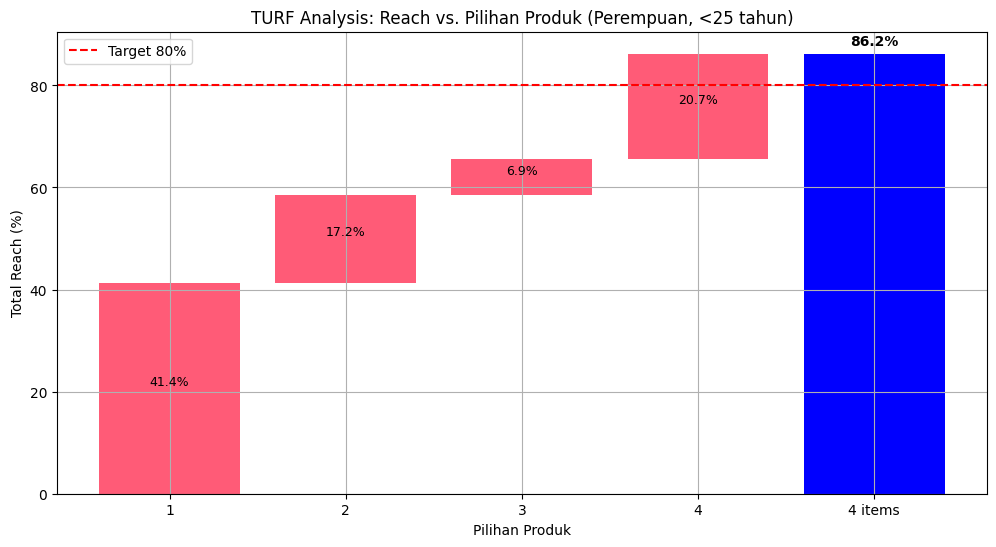

Untuk mencapai minimal 80%, perlu 4 produk.

Produk yang sebaiknya ditampilkan di area kasir untuk pelanggan (Perempuan, <25 tahun):
1. Produk R
2. Produk I
3. Produk F
4. Produk M


In [6]:
# @title Reach vs. Pilihan Produk berdasarkan Gender & Usia
Gender = "Perempuan"  #@param ["All", "Perempuan", "Laki-laki"]
Kelompok_Usia = "<25 tahun"  #@param ["All", "<25 tahun","25-34", "≥35 tahun"]
Target_dalam_persen = 80  #@param {type:"integer"}

import pandas as pd
import matplotlib.pyplot as plt

# Baca data
data_used = pd.read_excel(url)

# Filter Gender
if Gender != "All":
    data_used = data_used[data_used["Gender"] == Gender]

# Filter Usia
if Kelompok_Usia == "<25 tahun":
    data_used = data_used[data_used["Usia"] < 25]
elif Kelompok_Usia == "≥25 tahun":
    data_used = data_used[data_used["Usia"] >= 25]

if len(data_used) == 0:
    raise SystemExit("Data kosong! Program dihentikan.")

# Hitung target reach
target_reach_pct = Target_dalam_persen / 100
target_reach = int(target_reach_pct * len(data_used))

# Tentukan kolom produk dan urutkan berdasarkan popularitas
index_ = data_used.columns.get_loc("Produk A")
reach_per_item = data_used.iloc[:, index_:].sum(axis=0).sort_values(ascending=False)

# Algoritma greedy untuk memilih kombinasi produk terbaik
selected_items = []
current_reach = set()
reach_progress = []

for item in reach_per_item.index:
    new_reach = current_reach | set(data_used.index[data_used[item] == 1])
    selected_items.append(item)
    reach_progress.append(len(new_reach) / len(data_used))
    if len(new_reach) >= target_reach:
        break
    current_reach = new_reach

# Hitung incremental reach
incrementals = [reach_progress[0]] + [
    reach_progress[i] - reach_progress[i-1] for i in range(1, len(reach_progress))
]

# Visualisasi
plt.figure(figsize=(12, 6))
bottoms = 0
for i, inc in enumerate(incrementals):
    plt.bar(f"{i+1}", inc * 100, bottom=bottoms, color="#ff5b77")
    plt.text(i, bottoms + inc * 50, f"{inc*100:.1f}%", ha="center", va="bottom", fontsize=9)
    bottoms += inc * 100

plt.axhline(y=target_reach_pct * 100, color="r", linestyle="--", label=f"Target {target_reach_pct*100:.0f}%")
plt.bar(f"{len(selected_items)} items", reach_progress[-1] * 100, color="blue")
plt.text(len(selected_items), reach_progress[-1] * 100 + 1,
         f"{reach_progress[-1]*100:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.xlabel("Pilihan Produk")
plt.ylabel("Total Reach (%)")
plt.title(f"TURF Analysis: Reach vs. Pilihan Produk ({Gender}, {Kelompok_Usia})")
plt.legend()
plt.grid(True)
plt.savefig("reach_vs_produk.png")
plt.show()

# Output hasil
max_reach = max(reach_progress)

if max_reach >= target_reach_pct:
    print(f"Untuk mencapai minimal {target_reach_pct*100:.0f}%, perlu {len(selected_items)} produk.")
else:
    print(f"Tidak dapat mencapai {target_reach_pct*100:.0f}%. Maksimal hanya {max_reach*100:.0f}%, dengan {len(selected_items)} produk.")

print(f"\nProduk yang sebaiknya ditampilkan di area kasir untuk pelanggan ({Gender}, {Kelompok_Usia}):")
for i, produk in enumerate(selected_items):
    print(f"{i+1}. {produk}")


## **Tujuan Analisis**

Tujuan dari analisis ini untuk mengetahui produk impulsif apa saja sekiranya menarik akan menarik perhatian pelangggan di supermarket. Kemudian dari analisis ini kita dapat menentukan kombinasi produk yang paling optimal untuk ditata di area rak kasir agar setidaknya dapat menjangkau 80% pelanggan. Menganalisa perbedaan pilihan priduk antar pelanggan dengan kategori umum dan pelanggan dengan kategori khusus: yakni perempuan di bawah 25 tahun, serta memberi saran penataan yang efektif.

## **Hasil Analisis**
###Target Reach: 80%

**Kategori umum**

Total Reach yang Dicapai: 82.5%

Jumlah produk yang dibutuhkan: 6 produk

 Untuk kategori ini, diperlukan 6 produk impulsif yang optimal yang dapat menjangkau 82,5 dari seluruh pelanggan untuk dipajang di rak area kasir.

 Produk yang paling optimal antara lain:
 1. Produk M
 2. Produk P
 3. Produk N
 4. Produk B
 5. Produk R
 6. Produk I.

**Kategori khusus**

Total Reach yang Dicapai: 86,2%

Jumlah Produk yang Dibutuhkan: 4 produk.

Untuk segmen ini, hanya menampilkan 4 produk saja, sudah dapat menjangkau lebih dari 86% pelanggan, sehingga sangat efisien dari sisi space di area kasir.

Produk yang sebaiknya ditampilkan di area kasir berdasarkan segmen ini:
1. Produk R
2. Produk I
3. Produk F
4. Produk M

**___________________________________________________________________**

Terdapat perbedaan hasil di mana ternyata dibutuhkan 6 produk impulsif untuk mencapai target dengan kategori **seluruh pelanggan** dengan capaian target sejauh 82,5%. Sedangkan untuk segmen khusus yakni pelanggan perempuan di bawah 25 tahun, dengan capaian target hingga 86,2% ternyata 4 produk saja sudah cukup untuk melampaui target. Ini menunjukkan bahwa strategi dapat menghasilkan efisiensi ruang sekaligus protensi penjualan yang lebih tinggi berdasarkan segmen pelanggan.

## **Insight**

- Penempatan produk alangkah baiknya jika disesuaikan dengan segmen target pelanggan
- Segmentasi khusus berdasarkan usia dan gender dinilai sangat membantu dalam penyusunan strategi display di area kasir agar tepat sasaran.
- Produk R dapat menjadi produk maskot untuk segmen khusus karena memberikan impact paling besar. Produk ini cocok dijadikan produk utama dalam display kasir.
- Dengan adanya ruang terbatas pada area kasir, mengetahui dan memahami preferensi pilihan tiap segmen dapat menghasilkan penyusunan produk impulsif yang lebih efisien dan memiliki impact yang lebih besar.



